In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import scipy

# L03

In the following experiments I use PySINDy to find the underlying dynamics of a system soly based on data. By first simulating a dynamical system with a conventional numerical integrator, I aim to show how one could (re)-discover the dynamics by taking looking at each snapshot in time from the output of the numerical integrator.

## (E7.4) Finding the dynamics of the Lorenz system with PySINDy

In this experiment I show how to find the dynamics of the Lorenz system. To do this I first integrate the following system with scipy's solve_ivp. To test the quality of the solution found via PySINDy I also simulate a similar system, but with other initial starting parameters. If the system obtained from PySINDy is correct, then this result sould also predict this other system. To make this experiment more realistic noise will be added to the measurements.

$$x' = \sigma (y-x)$$
$$y'= x(\rho - z) - y$$
$$ z' = xy - \beta z $$

In [2]:
def lorenz(t, vars, sigma, rho, beta):
    x, y, z = vars
    dx = sigma * (y - x)
    dy = x*(rho-z)-y
    dz = x*y - beta*z
    return np.array([dx, dy, dz])

In [3]:
dt = 0.002
ts = np.arange(0,100, dt)
t_span = (0,100)
y0_train = np.array([1,2,3])
y0_test = np.array([1,4,3])
constants = np.array([10, 28, 2.667])

In [4]:
sol_train = scipy.integrate.solve_ivp(
    fun=lorenz,
    t_span=t_span,
    t_eval=ts, 
    y0=y0_train,
    args=(constants)
)

sol_test = scipy.integrate.solve_ivp(
    fun=lorenz,
    t_span=t_span,
    t_eval=ts, 
    y0=y0_test,
    args=(constants)
)

Text(0.5, 0.92, 'Simulated data + noise')

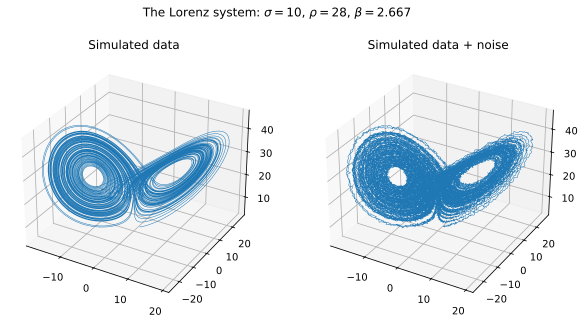

In [5]:
x_train = sol_train.y.T
x_train_noise = x_train + np.random.normal(0,0.2,x_train.shape)

x_test = sol_test.y.T

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1, projection="3d")
ax2 = fig.add_subplot(1,2,2, projection="3d")

plt.suptitle(r"The Lorenz system: $\sigma = 10$, $\rho = 28$, $\beta = 2.667$")
ax1.plot(*x_train.T, lw=0.5)
ax1.set_title("Simulated data")
ax2.plot(*x_train_noise.T, lw=0.5)
ax2.set_title("Simulated data + noise")

In the PySINDy framework you can add a threshold in order to the resulting terms. In the next sections I experiment with this threshold and what to set it in order to find the best solution.

#### Without threshold

Without noise:

In [6]:
# Code from https://github.com/dynamicslab/pysindy/blob/master/examples/15_pysindy_lectures.ipynb
import pysindy as ps

feature_names = ['x', 'y', 'z']
sparse_regression_optimizer = ps.STLSQ(threshold=0)
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train, t=dt)
model.print()

(x)' = -0.016 1 + -9.963 x + 9.975 y + 0.002 z + -0.001 x z + 0.001 y z
(y)' = 0.290 1 + 27.674 x + -0.873 y + -0.039 z + -0.006 x^2 + 0.006 x y + -0.990 x z + -0.001 y^2 + -0.002 y z + 0.001 z^2
(z)' = -0.596 1 + 0.039 x + -0.019 y + -2.586 z + 0.012 x^2 + 0.988 x y + -0.001 x z + 0.002 y^2 + -0.003 z^2


With noise:

In [7]:
feature_names = ['x', 'y', 'z']
sparse_regression_optimizer = ps.STLSQ(threshold=0)
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_noise, t=dt)
model.print()

(x)' = 1.727 1 + -9.306 x + 9.577 y + -0.221 z + -0.035 x^2 + 0.033 x y + -0.018 x z + -0.008 y^2 + 0.010 y z + 0.007 z^2
(y)' = -0.126 1 + 27.108 x + -0.547 y + 0.016 z + 0.003 x^2 + -0.001 x y + -0.974 x z + -0.011 y z + -0.001 z^2
(z)' = 0.666 1 + 0.149 x + -0.082 y + -2.755 z + -0.013 x^2 + 1.005 x y + -0.004 x z + 0.001 y^2 + 0.002 y z + 0.003 z^2


Partial conclusion:
The solutions without a threshold does not look like the real system.

#### With threshold

In [8]:
feature_names = ['x', 'y', 'z']
sparse_regression_optimizer = ps.STLSQ(threshold=0.1)
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train, t=dt)
model.print()

(x)' = -10.004 x + 10.004 y
(y)' = 27.779 x + -0.948 y + -0.993 x z
(z)' = -2.667 z + 0.999 x y


In [9]:
feature_names = ['x', 'y', 'z']
sparse_regression_optimizer = ps.STLSQ(threshold=0.1)
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_noise, t=dt)
model.print()

(x)' = -9.952 x + 9.960 y
(y)' = 27.568 x + -0.883 y + -0.988 x z
(z)' = -2.665 z + 0.998 x y


Partial conclusion: These solutions looks a lot better than the previous.

#### Setting the correct threshold

To find the most optimal threshold I make a linear scan through 0 to 1. I use the noisy data and compare the resulting system to the real data. I use two different metrics: (a) the one provided by PySINDy and (b) the MSE between the found test system and the true simulated system without noise.

In [10]:
from sklearn import metrics

threshold_scan = np.linspace(0, 1.0, 30)

mse_sim = np.zeros(len(threshold_scan))
mse = np.zeros(len(threshold_scan))
for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.STLSQ(threshold=threshold)
    model = ps.SINDy(
        feature_names=feature_names, 
        optimizer=sparse_regression_optimizer
    )
    model.fit(x_train_noise, t=dt, quiet=True)

    x_test_sim = model.simulate(y0_test, t=ts)
    mse[i] = model.score(x_test, ts, metric=metrics.mean_squared_error)
    mse_sim[i] = np.mean((x_test - x_test_sim) ** 2)

Text(0.5, 1.0, 'MSE (manual)')

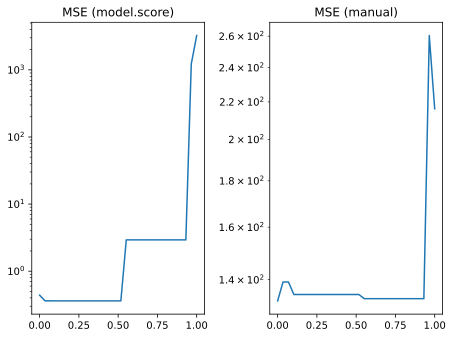

In [11]:
fig, axs = plt.subplots(1,2)
fig.set_tight_layout(True)

axs[0].semilogy(threshold_scan, mse)
axs[0].set_title("MSE (model.score)")
axs[1].semilogy(threshold_scan, mse_sim)
axs[1].set_title("MSE (manual)")

The big spike towards one is a consequence of the many of the terms in the last two equation diaspere. Cruriosly the two methods of calculating the error does not give the same answer. The left (Based on PySINDy) give the best threshold $\approx$ 0.25. The right (calculating the MSE manually) give the best threshold at $\approx$ 0.75.

The below model shows what happens when threshold is set to 1. It can be seen that many of the terms is not pressent in the model:

In [12]:
feature_names = ['x', 'y', 'z']
sparse_regression_optimizer = ps.STLSQ(threshold=1)
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_noise, t=dt)
model.print()

(x)' = -9.952 x + 9.960 y
(y)' = -2.824 x
(z)' = 0.000


/Users/louiss/code/uni/master/SML/.venv/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (1) and eliminated all coefficients
  warnings.warn(


According to the the left plot the best solution is found when the threshold is set to ca: 0.25: 

In [13]:
feature_names = ['x', 'y', 'z']
sparse_regression_optimizer = ps.STLSQ(threshold=0.25)
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_noise, t=dt)
model.print()

(x)' = -9.952 x + 9.960 y
(y)' = 27.568 x + -0.883 y + -0.988 x z
(z)' = -2.665 z + 0.998 x y


According to the the left plot the best solution is found when the threshold is set to ca: 0.75: 

In [21]:
feature_names = ['x', 'y', 'z']
sparse_regression_optimizer = ps.STLSQ(threshold=0.75)
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_noise, t=dt)
model.print()

(x)' = -9.952 x + 9.960 y
(y)' = 25.415 x + -0.946 x z
(z)' = -2.665 z + 0.998 x y


With the true system being:


$$ (x)' = -10 x + 10 y $$

$$ (y)' = 10 x + - x z - y$$

$$ (z)' = -2.667 z + x y $$

the best model is seen to be with $\approx$ 0.25. I dont know why my manual MSE gives the wrong answer.


The conclusion for this experiment is that PySINDy is able to find the governing equations for a dynamical system on the conditions that there are not to much noise, that there is enough data and that the threshold is set correctly. 

## (E.7.7)

In this experiment I tried to use the PDE module in PySINDy. After a long time trying to fix issues I unfortunately had to give up.

$$ u_t + u_{xxx} - 6u u_z = 0$$

$$ u(x,t) = - \frac{c}{2} sech^2 \left(\frac{\sqrt{c}}{2} (x-ct)\right)$$

In [14]:
sech = lambda x: np.cosh(x)

def pde(x,t,c):
    return -(c/2)*(sech((np.sqrt(c) / 2)*(x-c*t))**2)

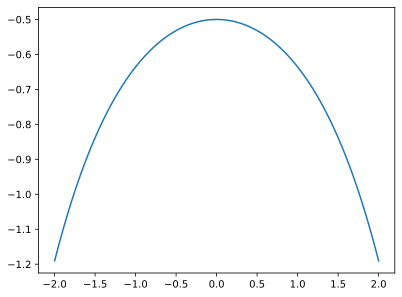

In [15]:
import pysindy as ps
ts = np.linspace(-2,2,100)
xs = pde(ts, 0, 1)
us = ps.AxesArray(np.ones((len(xs) * len(ts), 2)),{"ax_coord":1})

plt.plot(ts, xs)

In [16]:
library_functions = [lambda x: x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=2,
    spatial_grid=xs,
).fit([us])

optimizer = ps.STLSQ()

model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(xs, t=ts)
# model.print()

LinAlgError: Singular matrix